In [1]:
import pqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pprint import pp


# Выгрузка исходных данных для построения стратегии или модели


In [2]:
import requests

voluminous_stocks_tickers = requests.get(
    "https://github.com/aalitvinov/ITfF_tomtosov/raw/main/hw_data/voluminous_stocks_tickers.json"
).json()


In [3]:
from datetime import datetime

start = datetime(2008, 1, 1)
end = datetime(2023, 1, 1)


In [4]:
snp500 = yf.download(
    tickers="^GSPC",
    interval="1d",
    start=start,
    end=end,
    show_errors=False,
)


[*********************100%***********************]  1 of 1 completed


In [5]:
try:
    voluminous_stocks_yf = pd.read_csv(
        "./hw_data/voluminous_stocks_yf.csv.xz",
        compression="xz",
        header=[0, 1],
        index_col=[
            0,
        ],
        parse_dates=True,
    ).sort_index()
    snp500 = (
        pd.read_csv(
            "./hw_data/snp500_historical.csv",
            parse_dates=True,
        )
        .set_index("Date")
        .sort_index()
        .loc[:, "adj_close"]
    )
except FileNotFoundError:
    voluminous_stocks_yf: pd.DataFrame = (
        yf.download(
            tickers=voluminous_stocks_tickers,
            interval="1d",
            start=start,
            end=end,
            group_by="column",
            progress=True,
            show_errors=False,
        )
        .loc[:, ["Adj Close", "Volume"]]
        .rename({"Adj Close": "adj_close", "Volume": "volume"}, axis=1)
        .sort_index()
    )
    snp500: pd.Series = (
        yf.download(
            tickers="^GSPC",
            interval="1d",
            start=start,
            end=end,
            show_errors=False,
        )
        .loc[:, ["Adj Close", "Volume"]]
        .rename({"Adj Close": "adj_close", "Volume": "volume"}, axis=1)
        .sort_index()
        .loc[:, "adj_close"]
    )
    snp500.to_csv("./hw_data/snp500_historical.csv")
    voluminous_stocks_yf.to_csv(
        "./hw_data/voluminous_stocks_yf.csv.xz", compression="xz", index=True
    )


In [6]:
voluminous_stocks_yf.head(2)


adj_close                                                 \
                   AA        AAL      AAPL ABBV      ABEV        ABT   
Date                                                                   
2007-12-31  75.798203  13.867725  6.021055  NaN  1.550177  18.797380   
2008-01-02  74.927177  12.557314  5.922566  NaN  1.595544  18.683563   

                                                        ... volume            \
                  AFL         AIG       AIV       AMAT  ...   VXRT        VZ   
Date                                                    ...                    
2007-12-31  21.422634  762.888123  1.651104  13.551943  ...  14588   9628764   
2008-01-02  21.196888  736.717346  1.615924  13.284871  ...  11258  10865660   

                                                                        
           WLL      WMB       WMT      WPM        X       XOM XSPA  ZM  
Date                                                                    
2007-12-31 NaN  2233440  12176400  1740900  1984400  13990900  NaN NaN  
2008-01-02 NaN  4440873  19918600  6545500  5378700  23351900  NaN NaN  

[2 rows x 400 columns]

In [7]:
voluminous_stocks_yf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3778 entries, 2007-12-31 to 2022-12-30
Columns: 400 entries, ('adj_close', 'AA') to ('volume', 'ZM')
dtypes: float64(227), int64(173)
memory usage: 11.6 MB


In [8]:
snp500.info()

<class 'pandas.core.series.Series'>
Index: 3778 entries, 2007-12-31 to 2022-12-30
Series name: adj_close
Non-Null Count  Dtype  
--------------  -----  
3778 non-null   float64
dtypes: float64(1)
memory usage: 59.0+ KB


# Обработка финансовых данных


Удаление столбцов с акциями, у которых нет хотя бы 500 значений:


In [9]:
voluminous_stocks_yf = voluminous_stocks_yf.dropna(axis=1, thresh=500)


In [10]:
prices = voluminous_stocks_yf.loc[:, "adj_close"]
prices.head(3)


,AA,AAL,AAPL,ABBV,ABEV,ABT,AFL,AIG,AIV,AMAT,...,VLO,VTNR,VXRT,VZ,WMB,WMT,WPM,X,XOM,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2007-12-31,75.798203,13.867725,6.021055,NaN,1.550177,18.797380,21.422634,762.888123,1.651104,13.551943,...,39.632687,1.5,213.816284,19.082560,14.172917,33.862942,14.395689,105.885101,54.120598,NaN
2008-01-02,74.927177,12.557314,5.922566,NaN,1.595544,18.683563,21.196888,736.717346,1.615924,13.284871,...,39.304443,1.5,224.477493,18.872910,14.172917,33.414093,16.117754,99.518532,54.016617,NaN
2008-01-03,75.051643,11.991672,5.925303,NaN,1.618340,18.569731,21.467113,738.680054,1.580743,13.048324,...,37.595322,1.5,217.370026,18.960264,14.537341,33.043613,15.430621,98.441360,54.201496,NaN


In [11]:
volume = voluminous_stocks_yf.loc[:, "volume"] * prices
volume.head(3)


,AA,AAL,AAPL,ABBV,ABEV,ABT,AFL,AIG,AIV,AMAT,...,VLO,VTNR,VXRT,VZ,WMB,WMT,WPM,X,XOM,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2007-12-31,1.845306e+08,3.727506e+07,3.247355e+09,NaN,73633.429110,1.961502e+08,5.483766e+07,4.415406e+08,1.407931e+07,1.008766e+08,...,1.851523e+08,27915.0,3.119152e+06,1.837415e+08,3.165436e+07,4.123287e+08,2.506145e+07,2.101184e+08,7.571959e+08,NaN
2008-01-02,2.432623e+08,4.907398e+07,6.391508e+09,NaN,271242.415905,2.095573e+08,1.006810e+08,5.408868e+08,2.238292e+07,2.554787e+08,...,2.580416e+08,60.0,2.527168e+06,2.050666e+08,6.294013e+07,6.655620e+08,1.054988e+08,5.352803e+08,1.261391e+09,NaN
2008-01-03,2.249519e+08,5.683093e+07,4.989499e+09,NaN,214430.083632,2.024596e+08,1.105642e+08,4.008115e+08,1.857439e+07,2.087614e+08,...,4.330255e+08,450.0,1.274006e+06,1.709832e+08,7.916002e+07,6.542966e+08,1.064481e+08,3.121576e+08,1.038533e+09,NaN


In [12]:
prices, volume = pqr.utils.align(prices, volume)  # type: ignore
prices, volume = pqr.utils.replace_with_nan(prices, volume, to_replace=0)  # type: ignore
prices: pd.DataFrame = prices
volume: pd.DataFrame = volume


In [13]:
universe = (prices > 10) & (volume > 20_000_000)


In [14]:
universe.sum().sort_values(ascending=False)  # type: ignore


LOW     3778
KO      3778
MSFT    3778
BIDU    3778
BMY     3778
        ... 
ABEV       0
IDEX       0
DNN        0
SIRI       0
GSAT       0
Length: 191, dtype: int64

# Построение инвестиционной стратегии или финансовой модели


In [15]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns,
    universe_returns=pqr.prices_to_returns(prices),
)


<Axes: title={'center': 'EW_Benchmark returns'}, xlabel='EW_Benchmark'>

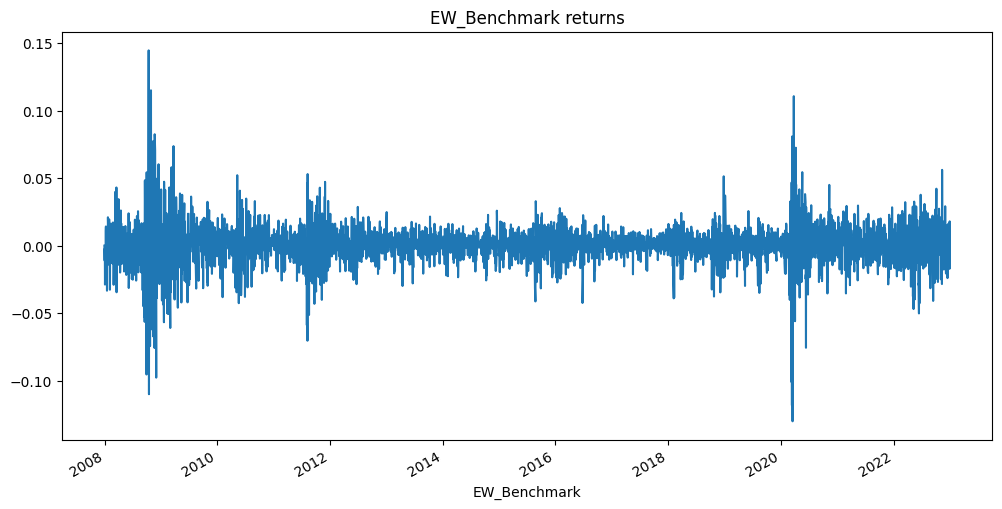

In [16]:
ew_benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="EW_Benchmark",
)

ew_benchmark.returns.plot(title="EW_Benchmark returns", figsize=(12, 6))


<Axes: title={'center': 'S&P 500 returns'}, xlabel='S&P 500'>

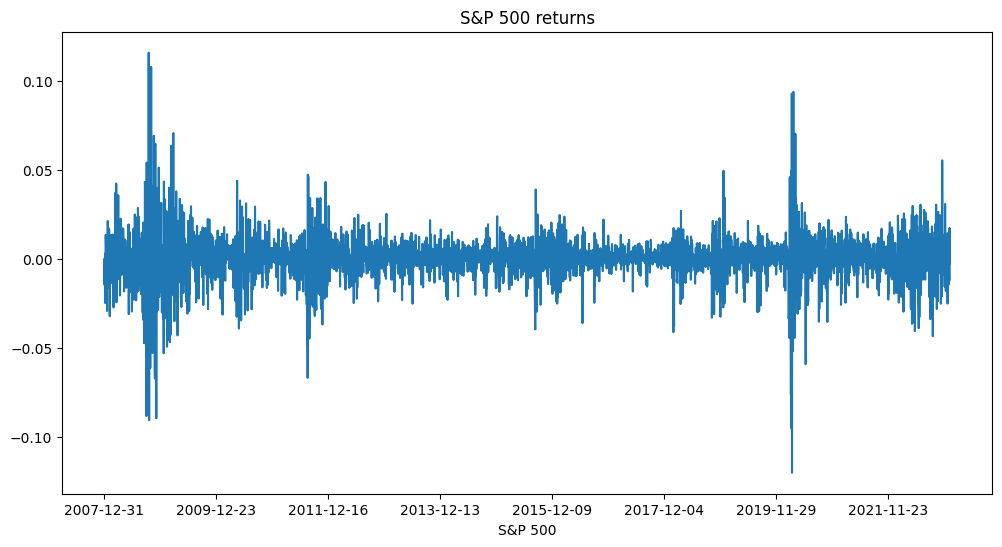

In [17]:
snp500_benchmark = pqr.Benchmark.from_index(index=snp500, name="S&P 500")

snp500_benchmark.returns.plot(title="S&P 500 returns", figsize=(12, 6))


In [18]:
table = pqr.metrics.Table()

# Monthly Mean Return metric
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=12,
    ),  # type: ignore
    multiplier=100,
    name="Monthly Mean Return, %",
)

# Monthly Volatility metric
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=12,
    ),  # type: ignore
    multiplier=100,
    name="Monthly Volatility, %",
)

# Alpha
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        statistics=True,
        benchmark=ew_benchmark,  # type: ignore
        annualizer=12,
    ),  # type: ignore
    multiplier=100,
    name="Alpha, %",
)


In [19]:
pp(table)


Table(metrics={'Monthly Mean Return, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033AD40>,
               'Monthly Volatility, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033B010>,
               'Alpha, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033AF80>})


In [20]:
fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,  # type: ignore
    name="Compounded Returns",
    benchmark=snp500_benchmark,
    log_scale=False,
    kwargs={"figsize": (10, 8)},
)

pp(fig)


Figure(metric=<function compounded_returns at 0x000001D9AD6E0F70>,
       multiplier=1.0,
       name='Compounded Returns',
       benchmark=Benchmark(name='S&P 500'),
       log_scale=False,
       kwargs={'figsize': (10, 8)})


In [21]:
summary = pqr.metrics.Dashboard([table, fig])
pp(summary)


Dashboard(items=[Table(metrics={'Monthly Mean Return, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033AD40>,
                                'Monthly Volatility, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033B010>,
                                'Alpha, %': <function Table.add_metric.<locals>.displayable_metric at 0x000001D9C033AF80>}),
                 Figure(metric=<function compounded_returns at 0x000001D9AD6E0F70>,
                        multiplier=1.0,
                        name='Compounded Returns',
                        benchmark=Benchmark(name='S&P 500'),
                        log_scale=False,
                        kwargs={'figsize': (10, 8)})])


In [22]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=3),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=3),
)


In [23]:
momentum = dynamic_transform(prices)
momentum.head(3)


,AA,AAL,AAPL,ABBV,ABEV,ABT,AFL,AIG,AIV,AMAT,...,VLO,VTNR,VXRT,VZ,WMB,WMT,WPM,X,XOM,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-07,-0.045965,-0.156356,NaN,NaN,NaN,-0.006411,-0.004311,-0.051458,NaN,-0.055743,...,-0.084106,NaN,NaN,-0.024948,-0.00531,-0.038081,0.041249,-0.122901,-0.017184,NaN
2008-01-08,-0.045965,-0.156356,NaN,NaN,NaN,-0.006411,-0.004311,-0.051458,NaN,-0.055743,...,-0.084106,NaN,NaN,-0.024948,-0.00531,-0.038081,0.041249,-0.122901,-0.017184,NaN
2008-01-09,-0.045965,-0.156356,NaN,NaN,NaN,-0.006411,-0.004311,-0.051458,NaN,-0.055743,...,-0.084106,NaN,NaN,-0.024948,-0.00531,-0.038081,0.041249,-0.122901,-0.017184,NaN


In [24]:
momentum_portfolios = pqr.factors.backtest_factor_portfolios(
    factor=momentum,  # на основе чего принимаем решения (матрица или таблица)
    strategies=pqr.factors.split_quantiles(3, better="more"),  # больще лучше
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=False,
)


In [25]:
pp(momentum_portfolios)


[Portfolio(name='Winners'),
 Portfolio(name='Neutral 1'),
 Portfolio(name='Losers')]


Считаем, сколько раз у конкретной компании из портфеля победителей были ненулевые веса, сортируем по убыванию:


In [26]:
(momentum_portfolios[0].holdings > 0).sum(axis=0).sort_values(ascending=False).head(15)


BIDU    1491
KSS     1425
X       1413
VLO     1410
HAL     1407
CF      1401
RCL     1377
AA      1371
NEM     1362
WPM     1347
NFLX    1344
UAL     1338
ISRG    1332
DVN     1329
LOW     1329
dtype: int64

In [27]:
momentum_portfolios[0].holdings.head()


,AA,AAL,AAPL,ABBV,ABEV,ABT,AFL,AIG,AIV,AMAT,...,VLO,VTNR,VXRT,VZ,WMB,WMT,WPM,X,XOM,ZM
Winners,,,,,,,,,,,,,,,,,,,,,
2008-01-07,0.0,0.0,0.0,0.0,0.0,0.027027,0.027027,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.027027,0.000000,0.027027,0.0,0.027027,0.0
2008-01-08,0.0,0.0,0.0,0.0,0.0,0.027027,0.027027,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.027027,0.000000,0.027027,0.0,0.027027,0.0
2008-01-09,0.0,0.0,0.0,0.0,0.0,0.027027,0.027027,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.027027,0.000000,0.027027,0.0,0.027027,0.0
2008-01-10,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,...,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.000000,0.0,0.000000,0.0
2008-01-11,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,...,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.000000,0.0,0.000000,0.0


,Winners,Neutral 1,Losers
"Monthly Mean Return, %",0.24 (0.79),0.59** (2.12),0.64** (1.82)
"Monthly Volatility, %",5.29,4.94,6.21
"Alpha, %",-0.19* (-1.80),0.17*** (2.87),0.13 (1.13)


TypeError: '<' not supported between instances of 'str' and 'Timestamp'

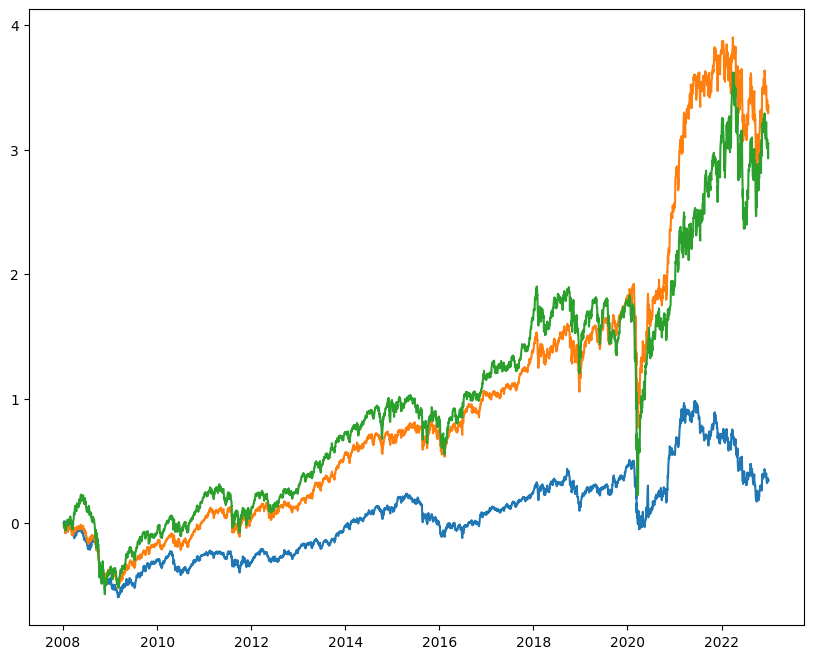

In [30]:
summary.display(momentum_portfolios)


# Аналитика и визуализация результатов
